# MSFT Stock Article extractions

In [ ]:
import requests

# api_key = '23f5208b7e2940aeb8b72c67195565b2'
api_key = 'bd9bb272078b41ebb0ee0a905d4a9532'
date_from = '2023-12-16'
date_to = '2024-01-15'
# Expanded list of sources
sources = 'bloomberg,cnbc,reuters,financial-times,techcrunch,the-wall-street-journal,the-verge,business-insider,the-economist,wired,engadget,bbc-news,fortune,techradar'

# Broadening the search query
query = 'Microsoft OR "MSFT" OR "Satya Nadella" OR "Windows" OR "Azure" OR "Office 365" OR "Xbox" OR "Surface" OR "Microsoft Teams" OR "LinkedIn"'

url = f'https://newsapi.org/v2/everything?q={query}&from={date_from}&to={date_to}&sources={sources}&apiKey={api_key}'
response = requests.get(url)
data = response.json()

# Check for 'articles' in response and extract headlines with publication dates
if 'articles' in data:
    news_data = [(article['title'], article['publishedAt'][:10]) for article in data['articles']]
    for headline, date in news_data:
        print(f"Date: {date}, Headline: {headline}")
else:
    print("Error or no articles found. Response:")
    print(data)


Date: 2023-12-22, Headline: 2024 in laptops: it’s shaping up to be a big year for Windows
Date: 2024-01-15, Headline: Microsoft unlocks Copilot AI inside Office apps for all businesses
Date: 2024-01-04, Headline: Microsoft's AI button for its Copilot tool marks its first major addition to PC keyboards in 30 years
Date: 2023-12-19, Headline: Video games in 2023: Acquisitions, layoffs, unions
Date: 2024-01-03, Headline: Assassin’s Creed Valhalla and Resident Evil 2 hit Xbox Game Pass this month — but no Call of Duty yet
Date: 2024-01-08, Headline: Belkin's Stand Pro iPhone dock uses Apple's DockKit to track you around a room
Date: 2024-01-15, Headline: Microsoft’s new Copilot Pro brings AI-powered Office features to the rest of us
Date: 2024-01-09, Headline: Microsoft's $10 billion partnership with OpenAI faces possible probe by EU watchdog
Date: 2024-01-12, Headline: Silicon Valley engineers joked you'd go to LinkedIn to retire. Then came the PIPs and layoffs.
Date: 2024-01-07, Headline

# Sentiment Analysis on News Articles

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Extract just the headlines from news_data
headlines = [headline for headline, _ in news_data]

# Tokenize and encode headlines
max_length = 512  # You can adjust this based on your requirements
inputs = tokenizer(headlines, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Predict sentiment
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Pair each sentiment score with its corresponding date
sentiment_data = []
for (headline, date), prediction in zip(news_data, predictions):
    sentiment_data.append({
        'date': date,
        'headline': headline,
        'sentiment_positive': prediction[0].item(),
        'sentiment_neutral': prediction[1].item(),
        'sentiment_negative': prediction[2].item()
    })


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
sentiment_data

[{'date': '2023-12-22',
  'headline': '2024 in laptops: it’s shaping up to be a big year for Windows',
  'sentiment_positive': 0.836638331413269,
  'sentiment_neutral': 0.15739025175571442,
  'sentiment_negative': 0.005971288774162531},
 {'date': '2024-01-04',
  'headline': "Microsoft's AI button for its Copilot tool marks its first major addition to PC keyboards in 30 years",
  'sentiment_positive': 0.017868157476186752,
  'sentiment_neutral': 0.9821285009384155,
  'sentiment_negative': 3.4337560919084353e-06},
 {'date': '2023-12-11',
  'headline': 'The ultra-customizable Arc browser is now available on Windows in beta',
  'sentiment_positive': 0.9999951124191284,
  'sentiment_neutral': 1.2478259350245935e-06,
  'sentiment_negative': 3.6383639780979138e-06},
 {'date': '2023-12-19',
  'headline': 'Video games in 2023: Acquisitions, layoffs, unions',
  'sentiment_positive': 0.9992341995239258,
  'sentiment_neutral': 2.52420386459562e-06,
  'sentiment_negative': 0.0007633515051566064},
 

# Historical Stock Data and Sentiment Analysis Combined

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# Convert sentiment_data to a DataFrame
sentiment_df = pd.DataFrame(sentiment_data)

# Convert date to datetime and set as index
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df.set_index('date', inplace=True)

# Aggregate sentiment scores by date
average_sentiment = sentiment_df.groupby('date').mean()

# Download stock data
ticker_symbol = 'MSFT'
stock_data = yf.download(ticker_symbol, start='2023-12-16', end='2024-01-15')

# Selecting the required columns
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Convert stock_data index to datetime
stock_data.index = pd.to_datetime(stock_data.index)

# Combine stock data with sentiment data
combined_data = stock_data.join(average_sentiment)

# Interpolate missing values
combined_data = combined_data.interpolate(method='time')

# Scale price-related columns
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
scaler_prices = StandardScaler()
combined_data[price_cols] = scaler_prices.fit_transform(combined_data[price_cols])

# Scale Volume column independently
scaler_volume = StandardScaler()
combined_data['Volume'] = scaler_volume.fit_transform(combined_data[['Volume']])

print(combined_data)

<ipython-input-4-352ed5fc53bd>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_sentiment = sentiment_df.groupby('date').mean()


[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2023-12-11 -1.353979 -1.629669 -1.193616 -0.303252  -0.303252  0.149133   
2023-12-12 -0.499782 -0.064145  0.301831  0.804998   0.804998 -0.047846   
2023-12-13  1.363590  1.723436  0.408159  0.801396   0.801396  0.371929   
2023-12-14  0.386851 -0.430545 -1.869314 -2.235481  -2.235481  1.217491   
2023-12-15 -1.941468 -1.185557 -1.131880 -0.508341  -0.508341  3.633038   
2023-12-18 -1.004370 -0.852464 -0.308697  0.182506   0.182506 -0.256142   
2023-12-19 -0.269118 -0.708120  0.089177  0.402002   0.402002 -0.338434   
2023-12-20  0.995964  0.829638  0.325844 -0.547927  -0.547927  0.053605   
2023-12-21  0.116535 -0.069701  0.157780  0.502751   0.502751 -0.537143   
2023-12-22  0.520205  0.357757  1.073567  0.876955   0.876955 -0.579476   
2023-12-26  0.995964  1.334825 

In [ ]:
import pandas as pd
df = pd.DataFrame(combined_data)
df

,Open,High,Low,Close,Adj Close,Volume,sentiment_positive,sentiment_neutral,sentiment_negative
Date,,,,,,,,,
2023-12-11,-1.353979,-1.629669,-1.193616,-0.303252,-0.303252,0.149133,0.919939,7.999084e-02,0.000070
2023-12-12,-0.499782,-0.064145,0.301831,0.804998,0.804998,-0.047846,0.608640,2.245864e-01,0.166773
2023-12-13,1.363590,1.723436,0.408159,0.801396,0.801396,0.371929,0.999783,2.920614e-05,0.000188
2023-12-14,0.386851,-0.430545,-1.869314,-2.235481,-2.235481,1.217491,0.853790,1.428777e-01,0.003333
2023-12-15,-1.941468,-1.185557,-1.131880,-0.508341,-0.508341,3.633038,0.686339,1.960745e-01,0.117586
2023-12-18,-1.004370,-0.852464,-0.308697,0.182506,0.182506,-0.256142,0.900094,1.239913e-02,0.087506
2023-12-19,-0.269118,-0.708120,0.089177,0.402002,0.402002,-0.338434,0.715582,1.104202e-01,0.173997
2023-12-20,0.995964,0.829638,0.325844,-0.547927,-0.547927,0.053605,0.509417,1.987391e-01,0.291844
2023-12-21,0.116535,-0.069701,0.157780,0.502751,0.502751,-0.537143,0.999988,4.727674e-08,0.000012


# Transformer Architecture

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping

selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative']
data = combined_data[selected_features]

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Prepare features and target for model training
X_train = train_data.drop('Close', axis=1)
y_train = train_data['Close']
X_val = val_data.drop('Close', axis=1)
y_val = val_data['Close']
X_test = test_data.drop('Close', axis=1)
y_test = test_data['Close']

# Define and compile the neural network model
model = Sequential()
model.add(Dense(32, activation='LeakyReLU', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='LeakyReLU'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,  # Set back to 50 or an arbitrarily large number
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Convert the epochs range object to a list
epochs_list = list(epochs)

# Plotting the training and validation loss
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(x=epochs_list, y=train_loss, mode='lines', name='Training Loss'))
loss_fig.add_trace(go.Scatter(x=epochs_list, y=val_loss, mode='lines', name='Validation Loss'))
loss_fig.update_layout(title='Training and Validation Loss per Epoch',
                       xaxis_title='Epochs',
                       yaxis_title='Loss',
                       legend_title='Type')
loss_fig.show()

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

# Reshape y_test and predictions for inverse transform
y_test_reshaped = y_test.values.reshape(-1, 1)
predictions_reshaped = predictions.reshape(-1, 1)

num_scaled_cols = 5

# Create separate dummy arrays for inverse scaling
dummy_array_y_test = np.zeros((len(y_test_reshaped), num_scaled_cols))
dummy_array_predictions = np.zeros((len(predictions_reshaped), num_scaled_cols))

# Fill in the 'Close' column values in the dummy arrays
# Assuming 'Close' is the last of the scaled columns
dummy_array_y_test[:, -1] = y_test_reshaped.flatten()
dummy_array_predictions[:, -1] = predictions_reshaped.flatten()

# Inverse transform the 'Close' prices using the dummy arrays
y_test_original = scaler_prices.inverse_transform(dummy_array_y_test)[:, -1]
predictions_original = scaler_prices.inverse_transform(dummy_array_predictions)[:, -1]

# Extracting testing dates
test_dates = test_data.index

# Plotting with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test_original, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions_original, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Stock Prices', xaxis_title='Date', yaxis_title='Stock Price', legend_title='Legend')
fig.show()

Epoch 1/50
2/2 [==============================] - 1s 277ms/step - loss: 0.7351 - val_loss: 0.1953
Epoch 2/50
2/2 [==============================] - 0s 60ms/step - loss: 0.3050 - val_loss: 0.0639
Epoch 3/50
2/2 [==============================] - 0s 71ms/step - loss: 0.3002 - val_loss: 0.0924
Epoch 4/50
2/2 [==============================] - 0s 42ms/step - loss: 0.1294 - val_loss: 0.1849
Epoch 5/50
2/2 [==============================] - 0s 67ms/step - loss: 0.1195 - val_loss: 0.1381
Epoch 6/50
2/2 [==============================] - 0s 67ms/step - loss: 0.1013 - val_loss: 0.0750
Epoch 7/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0736 - val_loss: 0.0232
Epoch 8/50
2/2 [==============================] - 0s 63ms/step - loss: 0.0465 - val_loss: 0.0105
Epoch 9/50
2/2 [==============================] - 0s 50ms/step - loss: 0.0145 - val_loss: 0.0664
Epoch 10/50
2/2 [==============================] - 0s 69ms/step - loss: 0.0840 - val_loss: 0.1522
Epoch 11/50
2/2 [===========

1/1 [==============================] - 0s 93ms/step
MSE: 0.016943015388848237, MAE: 0.1172690723510622, R^2: 0.9377325097819913


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833 (3.25 KB)
Trainable params: 833 (3.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, MultiHeadAttention, GlobalAveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping

selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative']
data = combined_data[selected_features]

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define and compile the neural network model
def create_model(input_shape):
    inp = Input(shape=input_shape)

    # LSTM Layer
    x = LSTM(128, return_sequences=True)(inp)
    x = Dropout(0.2)(x)

    # Transformer Layer using MultiHeadAttention
    attention = MultiHeadAttention(num_heads=2, key_dim=128)(x, x)
    x = GlobalAveragePooling1D()(attention)

    # Dense Layers for final predictions
    x = Dense(64, activation='LeakyReLU')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='LeakyReLU')(x)
    x = Dense(1)(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

# Reshape the data for LSTM layer
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
model = create_model((1, X_train.shape[1]))
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=8, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Convert the epochs range object to a list
epochs_list = list(epochs)

# Plotting the training and validation loss
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(x=epochs_list, y=train_loss, mode='lines', name='Training Loss'))
loss_fig.add_trace(go.Scatter(x=epochs_list, y=val_loss, mode='lines', name='Validation Loss'))
loss_fig.update_layout(title='Training and Validation Loss per Epoch',
                       xaxis_title='Epochs',
                       yaxis_title='Loss',
                       legend_title='Type')
loss_fig.show()

# Make predictions
# Reshape X_test for prediction
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Make predictions using the reshaped test data
predictions = model.predict(X_test_reshaped)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

# Reshape y_test and predictions for inverse transform
y_test_reshaped = y_test.values.reshape(-1, 1)
predictions_reshaped = predictions.reshape(-1, 1)

num_scaled_cols = 5

# Create separate dummy arrays for inverse scaling
dummy_array_y_test = np.zeros((len(y_test_reshaped), num_scaled_cols))
dummy_array_predictions = np.zeros((len(predictions_reshaped), num_scaled_cols))

# Fill in the 'Close' column values in the dummy arrays
# Assuming 'Close' is the last of the scaled columns
dummy_array_y_test[:, -1] = y_test_reshaped.flatten()
dummy_array_predictions[:, -1] = predictions_reshaped.flatten()

# Inverse transform the 'Close' prices using the dummy arrays
y_test_original = scaler_prices.inverse_transform(dummy_array_y_test)[:, -1]
predictions_original = scaler_prices.inverse_transform(dummy_array_predictions)[:, -1]

# Extracting testing dates
test_dates = test_data.index

# Plotting with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test_original, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions_original, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Stock Prices', xaxis_title='Date', yaxis_title='Stock Price', legend_title='Legend')
fig.show()

Epoch 1/50
2/2 [==============================] - 4s 585ms/step - loss: 0.7173 - val_loss: 4.1902
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 1.0300 - val_loss: 1.3871
Epoch 3/50
2/2 [==============================] - 0s 43ms/step - loss: 0.5981 - val_loss: 0.4608
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 1.2779 - val_loss: 0.6553
Epoch 5/50
2/2 [==============================] - 0s 42ms/step - loss: 0.4621 - val_loss: 0.3080
Epoch 6/50
2/2 [==============================] - 0s 42ms/step - loss: 0.6777 - val_loss: 0.1230
Epoch 7/50
2/2 [==============================] - 0s 46ms/step - loss: 0.4455 - val_loss: 0.0539
Epoch 8/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0709 - val_loss: 0.0360
Epoch 9/50
2/2 [==============================] - 0s 40ms/step - loss: 0.5899 - val_loss: 0.5075
Epoch 10/50
2/2 [==============================] - 0s 37ms/step - loss: 0.4422 - val_loss: 0.0457
Epoch 11/50
2/2 [===========

1/1 [==============================] - 0s 477ms/step
MSE: 0.030324160532331598, MAE: 0.13885356432971835, R^2: 0.8885552939673839


In [ ]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1, 8)]               0         []                            
                                                                                                  
 lstm_12 (LSTM)              (None, 1, 128)               70144     ['input_13[0][0]']            
                                                                                                  
 dropout_26 (Dropout)        (None, 1, 128)               0         ['lstm_12[0][0]']             
                                                                                                  
 multi_head_attention_12 (M  (None, 1, 128)               131968    ['dropout_26[0][0]',          
 ultiHeadAttention)                                                  'dropout_26[0][0]']   

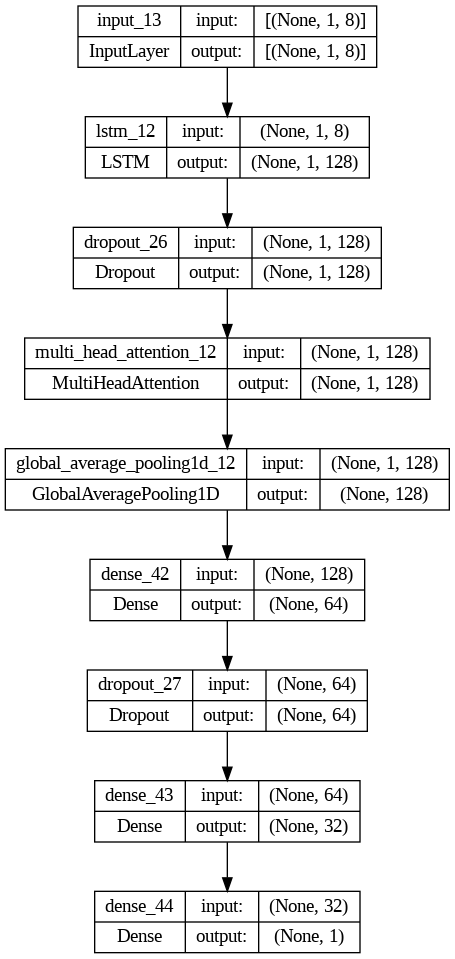

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Sequential model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
